In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, Variable, ParticleFile
import numpy as np
import xarray as xr
from glob import glob
from datetime import timedelta as delta
import matplotlib.pyplot as plt
import h3
import cartopy

import pickle
import sys
sys.path.append('../functions')
import hexbin_functions as hexfunc

/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


In [32]:
with open('../data/hexgrid_no_coast.pkl', 'rb') as f:
    hexagons_grid = pickle.load(f)
    
grid = hexfunc.hexGrid(hexagons_grid)

In [33]:
class EnsembleParticle(JITParticle):
    """
    Particle class definition with additional variables
    """
    # dynamic variables
    u = Variable('u', dtype=np.float32, initial=0)
    v = Variable('v', dtype=np.float32, initial=0)
    w = Variable('w', dtype=np.float32, initial=0)
    
    hexbin_id = Variable('hexbin_id', dtype=np.int16, initial=0)

In [34]:
def SampleField(particle, fieldset, time):
    """
    Sample the fieldset at the particle location and store it in the
    particle variable.
    """
    (ui, vi, wi) = fieldset.UVW.eval(time, particle.depth, particle.lat, particle.lon, 
                                     particle=particle, applyConversion=False)
    particle.u = ui
    particle.v = vi
    particle.w = wi

In [35]:
def compute_cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two 2D vectors."""
    dot_product = np.dot(vec1, vec2)
    magnitude1 = np.linalg.norm(vec1)
    magnitude2 = np.linalg.norm(vec2)
    return dot_product / (magnitude1 * magnitude2)

def compute_correlation_function(x_components, y_components, max_lag):
    """
    Compute the correlation function based on lag for a set of 2D vectors.

    Parameters:
    - x_components (list): List of x-components of the 2D vectors.
    - y_components (list): List of y-components of the 2D vectors.
    - max_lag (int): Maximum lag to consider for computing the correlation function.

    Returns:
    - correlations (list): List of tuples containing the lag and the average correlation for that lag.

    The function computes the correlation function based on lag for a set of 2D vectors.
    It calculates the correlation between each pair of vectors separated by a lag value
    ranging from 1 to max_lag. The correlation is computed using the Pearson correlation
    coefficient. The average correlation for each lag is then calculated and stored in a list
    of tuples, where each tuple contains the lag and the average correlation for that lag.
    The list of tuples is returned as the output of the function.
    """
    n = len(x_components)
    correlations = []

    for lag in range(1, max_lag + 1):
        lag_correlations = []

        for i in range(n - lag):
            vec1 = (x_components[i], y_components[i])
            vec2 = (x_components[i + lag], y_components[i + lag])
            correlation = compute_cosine_similarity(vec1, vec2)
            lag_correlations.append(correlation)

        average_correlation = np.mean(lag_correlations)
        correlations.append(average_correlation)

    return correlations

In [3]:
start_time = np.datetime64('2010-01-02')

loc1_lon = -74.0
loc1_lat = 35.5

# Find the hexagon containing the location
loc1_hex = h3.geo_to_h3(loc1_lat, loc1_lon, 3)
loc1_lat, loc1_lon = h3.h3_to_geo(loc1_hex)
lon_0 = loc1_lon
lat_0 = loc1_lat

# Define the rings where we place the particles
span = 0.75
L_range = np.linspace(-span, span, 15)
theta_range = np.arange(0, 2*np.pi, np.pi/20)
lonp = [lon_0]
latp = [lat_0]

for r in L_range:
    for theta in theta_range:
    
        lonp.append(lon_0 + np.sin(theta)*r) 
        latp.append(lat_0 + np.cos(theta)*r)
        
times = [start_time]*len(lonp)
        
print("N particles: ", len(lonp))

N particles:  601


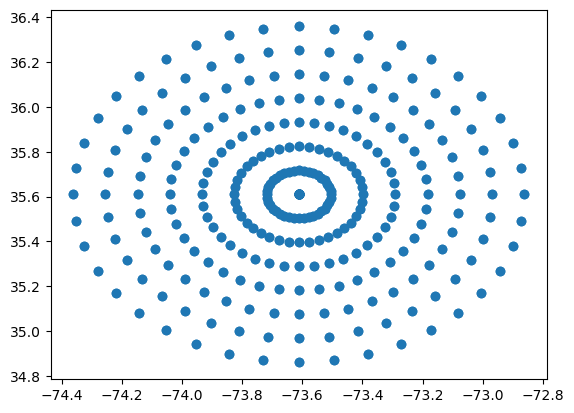

In [4]:
plt.scatter(lonp, latp)

In [12]:
loc1_lon = -74.0
loc1_lat = 35.5

# Find the hexagon containing the location
loc1_hex = h3.geo_to_h3(loc1_lat, loc1_lon, 3)
loc1_lat, loc1_lon = h3.h3_to_geo(loc1_hex)
lon_0 = loc1_lon
lat_0 = loc1_lat

# Define the rings where we place the particles
span = 1.6
L_range = np.arange(-span, span, 0.01)
theta_range = np.arange(0, 2*np.pi, np.pi/2)
lonp = [lon_0]
latp = [lat_0]

max_lag = 200
R_members = np.zeros((50, max_lag))
theta = np.pi/2

for member in range(1, 51):
    print(f"Member {member}")

    data_path = '/storage/shared/oceanparcels/input_data/NEMO_Ensemble/'
    ufiles = sorted(glob(f"{data_path}NATL025-CJMCYC3.{member:03d}-S/1d/2010/NATL025*U.nc"))
    vfiles = [f.replace('U.nc', 'V.nc') for f in ufiles]
    wfiles = [f.replace('U.nc', 'W.nc') for f in ufiles]
    mesh_mask = f"{data_path}GRID/coordinates_NATL025_v2.nc"
    maskfile = f"{data_path}GRID/NATL025-CJMenobs01_byte_mask.nc"

    filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
                'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
                'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
                'mask': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': maskfile}}
    variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz', 'mask': 'fmask'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'mask': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw'}}

    fieldset = FieldSet.from_nemo(filenames, variables, dimensions, netcdf_decodewarning=False)
        
    for r in L_range:
        
        # for theta in theta_range:
        lonp.append(lon_0 + np.sin(theta)*r) 
        latp.append(lat_0 + np.cos(theta)*r)

    end_time = np.datetime64('2010-01-02') + np.timedelta64(1, 'h')
    times = [np.datetime64('2010-01-02')]*len(lonp)
    depp = np.zeros(len(lonp))
    pset = ParticleSet(fieldset, EnsembleParticle, lon=lonp, lat=latp, depth=depp, time=times)
        
    pset.execute([SampleField], 
                dt=delta(hours=1), endtime=end_time)

    R_values = compute_correlation_function(pset.u, pset.v, max_lag)    
    R_members[member-1, :] = np.array(R_values)


Member 1
100%|██████████| 3600.0/3600.0 [00:00<00:00, 36183.87it/s]
Member 2
100%|██████████| 3600.0/3600.0 [00:00<00:00, 35157.62it/s]
Member 3
100%|██████████| 3600.0/3600.0 [00:00<00:00, 34762.55it/s]
Member 4
100%|██████████| 3600.0/3600.0 [00:00<00:00, 33926.42it/s]
Member 5
100%|██████████| 3600.0/3600.0 [00:00<00:00, 33412.24it/s]
Member 6
100%|██████████| 3600.0/3600.0 [00:00<00:00, 32699.52it/s]
Member 7
100%|██████████| 3600.0/3600.0 [00:00<00:00, 32237.63it/s]
Member 8
100%|██████████| 3600.0/3600.0 [00:00<00:00, 31542.18it/s]
Member 9
100%|██████████| 3600.0/3600.0 [00:00<00:00, 30693.02it/s]
Member 10
100%|██████████| 3600.0/3600.0 [00:00<00:00, 29914.92it/s]
Member 11
100%|██████████| 3600.0/3600.0 [00:00<00:00, 29573.28it/s]
Member 12
100%|██████████| 3600.0/3600.0 [00:00<00:00, 28986.65it/s]
Member 13
100%|██████████| 3600.0/3600.0 [00:00<00:00, 29216.78it/s]
Member 14
100%|██████████| 3600.0/3600.0 [00:00<00:00, 28158.98it/s]
Member 15
100%|██████████| 3600.0/3600.0 [0

In [13]:
# COmpute stats
L_r = np.zeros(50)
criterium = 0.1

for i in range(0,50):
    if np.all(R_members[i,:] >= criterium, axis=0):
        # skip this iteration
        L_r[i] = np.nan
    elif np.all(R_members[i,:] == 0, axis=0):
        L_r[i] = np.nan
    else:
        L = np.where(R_members[i, :] < criterium)[0][0]
        L_r[i] = L
    
L_r_std = np.nanstd(L_r)*0.01
L_r_mean = np.nanmean(L_r)*0.01

print(f"Mean L_r: {L_r_mean}, std L_r: {L_r_std}")

Mean L_r: 0.7261538461538461, std L_r: 0.2204728645971396


<>:13: SyntaxWarning: invalid escape sequence '\p'
<>:13: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_246205/3285800218.py:13: SyntaxWarning: invalid escape sequence '\p'
  plt.scatter(L_r_mean + L_r_std, 0, color='r', marker='^', label='Mean $L_R \pm \sigma$', s=10, zorder=10)


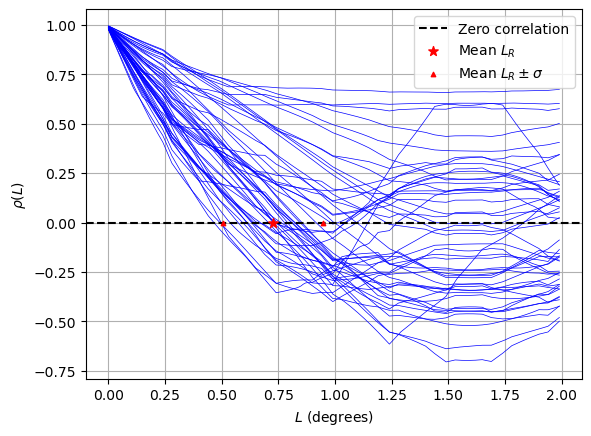

In [32]:
lag_array = np.arange(0, max_lag)*0.01

for member in range(1, 51):
    plt.plot(lag_array, R_members[member - 1, :], color='blue', linewidth=0.5)
    
plt.grid()

plt.axhline(y=0, color='k', linestyle='--', label='Zero correlation')



plt.scatter(L_r_mean, 0, color='r', marker='*', label='Mean $L_R$', s=50, zorder=10)
plt.scatter(L_r_mean + L_r_std, 0, color='r', marker='^', label='Mean $L_R \pm \sigma$', s=10, zorder=10)
plt.scatter(L_r_mean - L_r_std, 0, color='r', marker='^', s=10, zorder=10)
# plt.axvline(x=L_r_mean + L_r_std, color='r', linestyle='--', lw=1, label='Mean $L_R \pm \sigma$')
# plt.axvline(x=L_r_mean - L_r_std, color='r', linestyle='--', lw=1)

plt.xlabel(r'$L$ (degrees)')
plt.ylabel(r'$\rho(L)$')
plt.legend()
# plt.ylim([1e-1, 1])

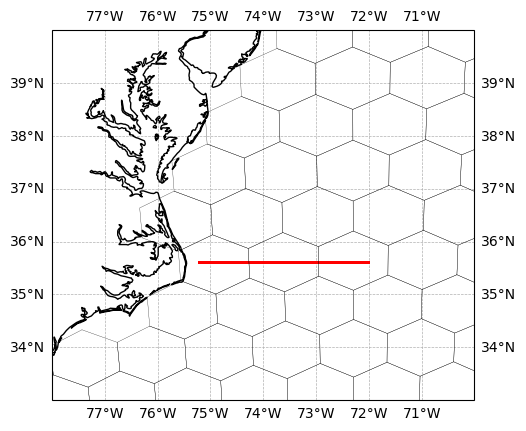

In [27]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

hexfunc.plot_hexagons(ax, hexagons_grid, colors='r', draw_edges=True, fill_polygons=False)

ax.scatter(pset.lon, pset.lat, 
           transform=cartopy.crs.PlateCarree(), s=0.2, c='r')

# ax.scatter(pset.lon[320:640], pset.lat[320:640], 
#            transform=cartopy.crs.PlateCarree(), s=0.2, c='b')

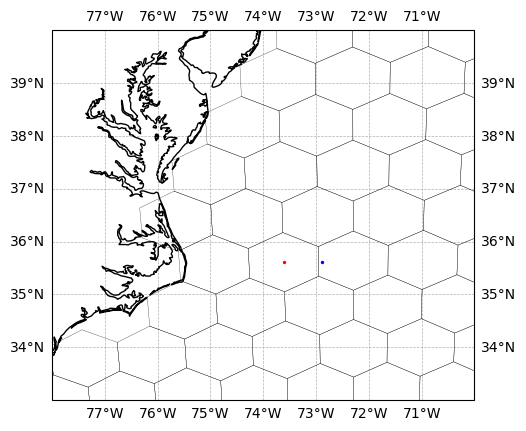

In [102]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

hexfunc.plot_hexagons(ax, hexagons_grid, colors='r', draw_edges=True, fill_polygons=False)

ax.scatter(loc1_lon, loc1_lat,
           transform=cartopy.crs.PlateCarree(), s=2, c='r')

ax.scatter(loc1_lon+L_r_mean, loc1_lat,
           transform=cartopy.crs.PlateCarree(), s=2, c='b')

In [ ]:
for r in L_range:
        for theta in theta_range:
        lonp.append(lon_0 + np.sin(theta)*r) 
        latp.append(lat_0 + np.cos(theta)*r)

# Temporal correlations

In [36]:
start_time = np.datetime64('2010-01-02')
end_time = np.datetime64('2011-01-02')
location = 'Cape Hatteras'
outfile = f"/storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/{location}/temp_correlation{location}_m{member:03d}.zarr"

N_particles = 1

# define time range with 1 day intervals
time_range = np.arange(start_time, end_time, delta(days=1))

loc1_lon = -74.0
loc1_lat = 35.5

# Find the hexagon containing the location
loc1_hex = h3.geo_to_h3(loc1_lat, loc1_lon, 3)
loc1_lat, loc1_lon = h3.h3_to_geo(loc1_hex)
lon_0 = loc1_lon
lat_0 = loc1_lat

# Define the rings where we place the particles
# span = 0.75
# L_range = np.linspace(-span, span, 15)


# theta_range = np.arange(0, 2*np.pi, np.pi/20)
lonp = [lon_0]*N_particles
latp = [lat_0]*N_particles

times = [start_time]*N_particles
depp = np.zeros(N_particles)


print("N particles: ", len(lonp))

for member in range(1, 2):
    print(f"Member {member}")

    data_path = '/storage/shared/oceanparcels/input_data/NEMO_Ensemble/'
    ufiles = sorted(glob(f"{data_path}NATL025-CJMCYC3.{member:03d}-S/1d/2010/NATL025*U.nc"))
    vfiles = [f.replace('U.nc', 'V.nc') for f in ufiles]
    wfiles = [f.replace('U.nc', 'W.nc') for f in ufiles]
    mesh_mask = f"{data_path}GRID/coordinates_NATL025_v2.nc"
    maskfile = f"{data_path}GRID/NATL025-CJMenobs01_byte_mask.nc"

    filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
                'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
                'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles},
                'mask': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': maskfile}}
    variables = {'U': 'vozocrtx', 'V': 'vomecrty', 'W': 'vovecrtz', 'mask': 'fmask'}
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
                'mask': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw'}}

    fieldset = FieldSet.from_nemo(filenames, variables, dimensions, netcdf_decodewarning=False)
        
    
    depp = np.zeros(len(lonp))
    pset = ParticleSet(fieldset, EnsembleParticle, lon=lonp, lat=latp, depth=depp, time=times)
    
    
    pfile = ParticleFile(outfile, pset, outputdt=delta(days=1), chunks=(len(pset), 1))
    
    pset.execute([SampleField], 
                dt=delta(days=1), endtime=end_time, output_file=pfile)

    # R_values = compute_correlation_function(pset.u, pset.v, max_lag)    
    # R_members_temp[member-1, :] = np.array(R_values)


N particles:  1
Member 1
INFO: Output files are stored in /storage/shared/oceanparcels/output_data/data_Claudio/NEMO_Ensemble/Cape Hatteras/temp_correlationCape Hatteras_m001.zarr.
 99%|█████████▉| 31363200.0/31536000.0 [08:30<00:02, 59123.74it/s]

TimeExtrapolationError: U sampled outside time domain at time 2010-12-31T12:00:00.000000000.In fset.computeTimeChunk Try setting allow_time_extrapolation to True

 99%|█████████▉| 31363200.0/31536000.0 [08:42<00:02, 59123.74it/s]

In [64]:
pset = xr.open_zarr(outfile)
max_lag = 7*5

R_values = compute_correlation_function(pset.u[0,:], pset.v[0,:], max_lag)    
    # R_members_temp[member-1, :] = np.array(R_values)

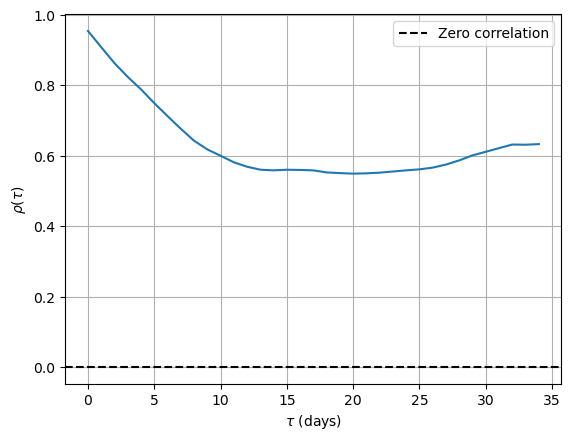

In [68]:
plt.plot(R_values)

# for member in range(1, 51):
    
plt.grid()

plt.axhline(y=0, color='k', linestyle='--', label='Zero correlation')



# plt.scatter(L_r_mean, 0, color='r', marker='*', label='Mean $L_R$', s=50, zorder=10)
# plt.scatter(L_r_mean + L_r_std, 0, color='r', marker='^', label='Mean $L_R \pm \sigma$', s=10, zorder=10)
# plt.scatter(L_r_mean - L_r_std, 0, color='r', marker='^', s=10, zorder=10)
# plt.axvline(x=L_r_mean + L_r_std, color='r', linestyle='--', lw=1, label='Mean $L_R \pm \sigma$')
# plt.axvline(x=L_r_mean - L_r_std, color='r', linestyle='--', lw=1)

plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'$\rho(\tau)$')
plt.legend()

In [24]:
R_members_temp

array([[nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
lag_array = np.arange(0, max_lag)

# for member in range(1, 51):
plt.plot(lag_array, R_members[0, :], color='blue', linewidth=0.5)
    
plt.grid()

plt.axhline(y=0, color='k', linestyle='--', label='Zero correlation')



plt.scatter(L_r_mean, 0, color='r', marker='*', label='Mean $L_R$', s=50, zorder=10)
plt.scatter(L_r_mean + L_r_std, 0, color='r', marker='^', label='Mean $L_R \pm \sigma$', s=10, zorder=10)
plt.scatter(L_r_mean - L_r_std, 0, color='r', marker='^', s=10, zorder=10)
# plt.axvline(x=L_r_mean + L_r_std, color='r', linestyle='--', lw=1, label='Mean $L_R \pm \sigma$')
# plt.axvline(x=L_r_mean - L_r_std, color='r', linestyle='--', lw=1)

plt.xlabel(r'$L$ (degrees)')
plt.ylabel(r'$\rho(L)$')
plt.legend()

In [6]:
R_members_temp = np.load('../data/temporal_correlations_Cape_Hatteras.npy')

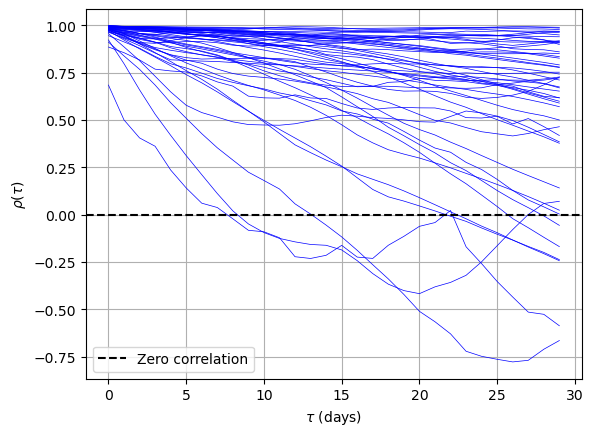

In [7]:
for member in range(0, 50):
    plt.plot(R_members_temp[member, :], color='blue', linewidth=0.5)
    
plt.grid()

plt.axhline(y=0, color='k', linestyle='--', label='Zero correlation')



# plt.scatter(L_r_mean, 0, color='r', marker='*', label='Mean $L_R$', s=50, zorder=10)
# plt.scatter(L_r_mean + L_r_std, 0, color='r', marker='^', label='Mean $L_R \pm \sigma$', s=10, zorder=10)
# plt.scatter(L_r_mean - L_r_std, 0, color='r', marker='^', s=10, zorder=10)
# plt.axvline(x=L_r_mean + L_r_std, color='r', linestyle='--', lw=1, label='Mean $L_R \pm \sigma$')
# plt.axvline(x=L_r_mean - L_r_std, color='r', linestyle='--', lw=1)

plt.xlabel(r'$\tau$ (days)')
plt.ylabel(r'$\rho(\tau)$')
plt.legend()